In [1]:
import numpy as np
import torch
from pathlib import Path
from pyro.distributions import Normal
import os
import matplotlib.pyplot as plt

from bnn_priors.models import DenseNet
from bnn_priors.inference import SGLDRunner
from bnn_priors import prior

%load_ext autoreload
%autoreload 2

In [8]:
data = np.load("../bnn_priors/data/snelson.npz")

device = ('cuda' if torch.cuda.is_available() else 'cpu')
x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(device=device, dtype=torch.get_default_dtype())
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = len(dataset), shuffle=True)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

In [19]:
epochs_per_cycle = 8000
warmup_epochs = 1000
sample_epochs = 1000
#N_steps = 10
skip = 50
#warmup = 500
cycles =  5
temperature = 1.0
momentum = 0.9
precond_update = None
lr = 5E-4


model = DenseNet(x_train.shape[-1], y_train.shape[-1], 128, noise_std=0.1)
model.to(x_train)
if torch.cuda.is_available():
    model = model.cuda()   # Resample model with He initialization so SGLD works.
model.train()

sgld = SGLDRunner(model=model, dataloader=dataloader, epochs_per_cycle=epochs_per_cycle, warmup_epochs=warmup_epochs, sample_epochs=sample_epochs, learning_rate=lr,
                  skip=skip, sampling_decay=True, cycles=cycles, temperature=temperature,
                  momentum=momentum, precond_update=precond_update)
sgld.run(progressbar=True)

samples = sgld.get_samples()

Cycle 4, Sampling: 100%|██████████| 8000/8000 [00:50<00:00, 158.37it/s]


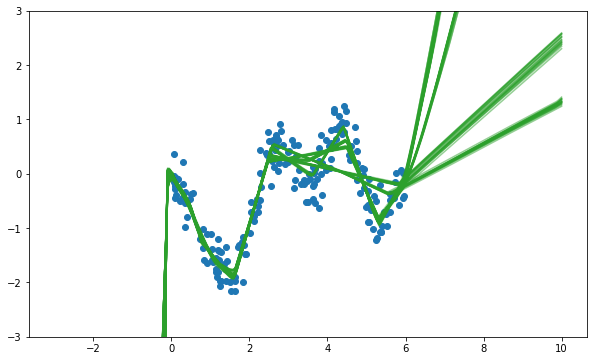

In [14]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(cycles*sgld.num_samples):
    param_sample = {param : value[i] for param, value in samples.items() if param != "lr"}
    model.load_state_dict(param_sample)
    with torch.no_grad():
        ax.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.5)
ax.scatter(x_train.cpu(), y_train.cpu())
ax.set_ylim(-3, 3);

(0, 5)

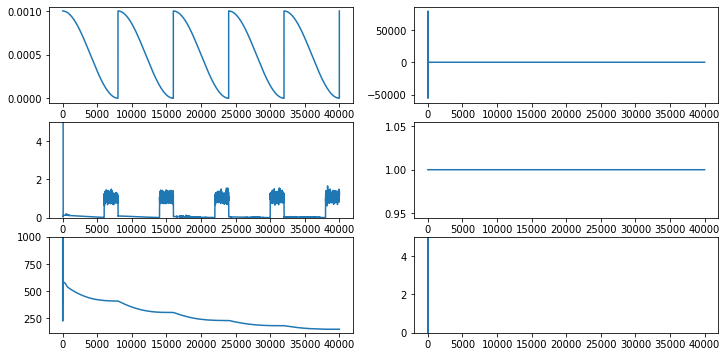

In [18]:
_, axes = plt.subplots(3, 2, figsize=(12, 6))
axes[0, 0].plot(sgld.metrics["lr"])
axes[0, 1].plot(sgld.metrics["log_prob_accept"])

ax = axes[2, 0]
ax.plot(sgld.metrics["loss"])
ax.set_ylim(115, 1000)

ax = axes[1, 0]
ax.plot(sgld.metrics["est_temperature/net.0.weight_prior"])
ax.set_ylim(0, 5)

axes[1, 1].plot(sgld.metrics["preconditioner/net.0.weight_prior"]);

ax = axes[2, 1]
ax.plot(sgld.metrics["est_config_temp/net.0.weight_prior"])
ax.set_ylim(0, 5)